<a href="https://colab.research.google.com/github/pratikiiitb2013/ERA/blob/main/S9/ERA1S9_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
from __future__ import print_function
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

%pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
#### Transforms - Aug ####
from albumentations import *
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.dropout.coarse_dropout import CoarseDropout
from albumentations.augmentations.geometric.transforms import PadIfNeeded
from albumentations.augmentations.crops.transforms import CenterCrop
# class TrainAlbumentation():
#   def __init__(self):
#     self.train_transform = Compose([
#       HorizontalFlip(),
#       ShiftScaleRotate(shift_limit=(-0.2, 0.2), scale_limit=(-0.2, 0.2), rotate_limit=(-15, 15), p=0.5),
#       PadIfNeeded(min_height=48, min_width=48, pad_height_divisor=None, pad_width_divisor=None, p=1.0),
#       CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=[255*0.485,255*0.456,255*0.406], mask_fill_value = None),
#       CenterCrop(32, 32, always_apply=False, p=1.0),
#       Normalize(
#         mean=[0.485,0.456,0.406],
#         std=[0.229,0.224,0.225],
#       ),
#       ToTensorV2()
#     ])

#   def __call__(self, img):
#     img = np.array(img)
#     img = self.train_transform(image = img)['image']
#     return img


# class TestAlbumentation():
#   def __init__(self):
#     self.test_transform = Compose(
#     [
#       Normalize(
#         mean=[0.485,0.456,0.406],
#         std=[0.229,0.224,0.225],
#       ),
#       ToTensorV2()
#     ])

#   def __call__(self, img):
#     img = np.array(img)
#     img = self.test_transform(image = img)['image']
#     return img

class TrainAlbumentation():
  def __init__(self):
    self.train_transform = Compose([
        Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225],
      ),
      HorizontalFlip(),
      ShiftScaleRotate(shift_limit=(-0.2, 0.2), scale_limit=(-0.2, 0.2), rotate_limit=(-15, 15), p=0.5),
      PadIfNeeded(min_height=48, min_width=48, pad_height_divisor=None, pad_width_divisor=None, p=1.0),
      CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=[0.485,0.456,0.406], mask_fill_value = None),
      CenterCrop(32, 32, always_apply=False, p=1.0),

      ToTensorV2()
    ])

  def __call__(self, img):
    img = np.array(img)
    img = self.train_transform(image = img)['image']
    return img


class TestAlbumentation():
  def __init__(self):
    self.test_transform = Compose(
    [
      Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225],
      ),
      ToTensorV2()
    ])

  def __call__(self, img):
    img = np.array(img)
    img = self.test_transform(image = img)['image']
    return img

# Dataset and Creating Train/Test Split

In [ ]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=32, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=TrainAlbumentation())
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=TestAlbumentation())
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

100%|██████████| 170498071/170498071 [00:16<00:00, 10643580.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


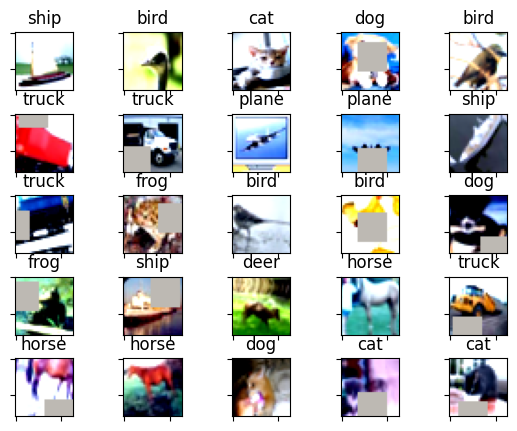

In [ ]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# # print labels
# for i in range(0,9):
#  plt.subplot(3, 3, i+1)
#  frame1 = plt.gca()
#  frame1.axes.xaxis.set_ticklabels([])
#  frame1.axes.yaxis.set_ticklabels([])
#  plt.imshow(np.transpose(((images[i]/2)+0.5).numpy(),(1,2,0)))
#  plt.title(classes[labels[i]])

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print labels
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,25):
 plt.subplot(5, 5, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((images[i]/2)+0.5).numpy(),(1,2,0)))
 plt.title(classes[labels[i]])

In [ ]:
normtype = 'bn'

def norms(normtype, embedding):
  if normtype=='bn':
     return nn.BatchNorm2d(embedding)
  elif normtype=='ln':
     return nn.GroupNorm(1, embedding)
  else:
    return nn.GroupNorm(4, embedding)

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.convblock0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    ###########################################################
    self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock1_d = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), dilation=2, padding=2, bias=False),
            norms(normtype, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock2_depth = nn.Sequential(
            depthwise_separable_conv(32, 128),
            norms(normtype, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.conv1X1_and_dilated3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), bias=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), dilation=8, bias=False),
            # norms(normtype, 32),
            # nn.ReLU(),
        )
    self.skip_with_stride2_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, stride=2, bias=False),
            # norms(normtype, 32),
            # nn.ReLU(),
        )
    ############################################################
    self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock4_d = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), dilation=2, padding=2, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock5_depth = nn.Sequential(
            depthwise_separable_conv(64, 128),
            norms(normtype, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.conv1X1_and_dilated6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), bias=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), dilation=4, bias=False),
            # norms(normtype, 32),
            # nn.ReLU(),
        )
    self.skip_with_stride2_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, stride=2, bias=False),
            # norms(normtype, 32),
            # nn.ReLU(),
        )
    ############################################################
    self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock7_d = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), dilation=2, padding=2, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock8_depth = nn.Sequential(
            depthwise_separable_conv(64, 128),
            norms(normtype, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.conv1X1_and_dilated9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), bias=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), dilation=2, bias=False),
            # norms(normtype, 32),
            # nn.ReLU(),
        )
    self.skip_with_stride2_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, stride=2, bias=False),
            # norms(normtype, 32),
            # nn.ReLU(),
        )
    ############################################################
    self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock10_d = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), dilation=2, padding=2, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
    self.convblock11_depth = nn.Sequential(
            depthwise_separable_conv(64, 128),
            norms(normtype, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

    self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

    self.convblock12_1X1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
    # self.convblock13_1X1 = nn.Sequential(
    #         nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
    #     )
    # self.convblock14_1X1 = nn.Sequential(
    #         nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
    #     )

  def forward(self, x):
    xi = self.convblock0(x)
    # xi = self.skip_with_stride2_1(xi)

    x = self.convblock1(xi) + self.convblock1_d(xi)
    x = self.convblock2_depth(x)
    xi = self.conv1X1_and_dilated3(x) + self.skip_with_stride2_1(xi)


    x = self.convblock4(xi) + self.convblock4_d(xi)
    x = self.convblock5_depth(x)
    xi = self.conv1X1_and_dilated6(x) + self.skip_with_stride2_2(xi)

    x = self.convblock7(xi) + self.convblock7_d(xi)
    x = self.convblock8_depth(x)
    xi = self.conv1X1_and_dilated9(x) + self.skip_with_stride2_3(xi)

    x = self.convblock10(xi) + self.convblock10_d(xi)
    x = self.convblock11_depth(x)

    x = self.gap(x)
    x = self.convblock12_1X1(x)
    # x = self.convblock13_1X1(x)
    # x = self.convblock14_1X1(x)

    x = x.view(-1, 10) #1x1x10> 10
    return F.log_softmax(x, dim=-1)
    # return xi


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,608
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]             320
           Conv2d-14          [-1,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # print(correct)
    # print(processed)
    # print(len(train_losses))

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
# model =  Net().to(device)

from torch.optim.lr_scheduler import StepLR



# model =  Net2().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# EPOCHS = 15
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
#     test(model, device, test_loader)


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # , weight_decay=0.0001
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


Loss=1.3124268054962158 Batch_id=390 Accuracy=35.60: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]



Test set: Average loss: 1.5962, Accuracy: 4062/10000 (40.62%)

EPOCH: 1


Loss=1.6761420965194702 Batch_id=390 Accuracy=47.13: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]



Test set: Average loss: 1.2035, Accuracy: 5651/10000 (56.51%)

EPOCH: 2


Loss=1.4602587223052979 Batch_id=390 Accuracy=52.82: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]



Test set: Average loss: 1.1005, Accuracy: 6040/10000 (60.40%)

EPOCH: 3


Loss=1.3045432567596436 Batch_id=390 Accuracy=56.35: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]



Test set: Average loss: 1.0464, Accuracy: 6283/10000 (62.83%)

EPOCH: 4


Loss=1.1542603969573975 Batch_id=390 Accuracy=59.21: 100%|██████████| 391/391 [00:28<00:00, 13.91it/s]



Test set: Average loss: 0.9941, Accuracy: 6456/10000 (64.56%)

EPOCH: 5


Loss=1.3309797048568726 Batch_id=390 Accuracy=61.03: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s]



Test set: Average loss: 1.1176, Accuracy: 6267/10000 (62.67%)

EPOCH: 6


Loss=0.8961206674575806 Batch_id=390 Accuracy=62.16: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]



Test set: Average loss: 0.9549, Accuracy: 6654/10000 (66.54%)

EPOCH: 7


Loss=1.0970371961593628 Batch_id=390 Accuracy=63.48: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]



Test set: Average loss: 0.8273, Accuracy: 7117/10000 (71.17%)

EPOCH: 8


Loss=0.941146731376648 Batch_id=390 Accuracy=64.44: 100%|██████████| 391/391 [00:28<00:00, 13.78it/s]



Test set: Average loss: 0.7987, Accuracy: 7206/10000 (72.06%)

EPOCH: 9


Loss=0.9620399475097656 Batch_id=390 Accuracy=65.58: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]



Test set: Average loss: 1.0208, Accuracy: 6642/10000 (66.42%)

EPOCH: 10


Loss=0.8726953268051147 Batch_id=390 Accuracy=66.37: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]



Test set: Average loss: 0.7443, Accuracy: 7454/10000 (74.54%)

EPOCH: 11


Loss=0.8622932434082031 Batch_id=390 Accuracy=67.28: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s]



Test set: Average loss: 0.7933, Accuracy: 7223/10000 (72.23%)

EPOCH: 12


Loss=1.0154157876968384 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:28<00:00, 13.70it/s]



Test set: Average loss: 0.7361, Accuracy: 7417/10000 (74.17%)

EPOCH: 13


Loss=0.9374479055404663 Batch_id=390 Accuracy=68.29: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]



Test set: Average loss: 0.7477, Accuracy: 7423/10000 (74.23%)

EPOCH: 14


Loss=1.0229909420013428 Batch_id=390 Accuracy=69.51: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s]



Test set: Average loss: 0.6970, Accuracy: 7609/10000 (76.09%)

EPOCH: 15


Loss=0.9422016143798828 Batch_id=390 Accuracy=69.57: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]



Test set: Average loss: 0.6602, Accuracy: 7718/10000 (77.18%)

EPOCH: 16


Loss=0.8223446011543274 Batch_id=390 Accuracy=70.11: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.6418, Accuracy: 7794/10000 (77.94%)

EPOCH: 17


Loss=0.9492659568786621 Batch_id=390 Accuracy=70.68: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]



Test set: Average loss: 0.7048, Accuracy: 7494/10000 (74.94%)

EPOCH: 18


Loss=0.821823000907898 Batch_id=390 Accuracy=71.06: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]



Test set: Average loss: 0.6432, Accuracy: 7776/10000 (77.76%)

EPOCH: 19


Loss=0.732282817363739 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]



Test set: Average loss: 0.6518, Accuracy: 7760/10000 (77.60%)

EPOCH: 20


Loss=0.6742942929267883 Batch_id=390 Accuracy=71.93: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]



Test set: Average loss: 0.6545, Accuracy: 7823/10000 (78.23%)

EPOCH: 21


Loss=0.7150813341140747 Batch_id=390 Accuracy=72.36: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]



Test set: Average loss: 0.6487, Accuracy: 7817/10000 (78.17%)

EPOCH: 22


Loss=0.7199124097824097 Batch_id=390 Accuracy=72.46: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 0.6042, Accuracy: 7945/10000 (79.45%)

EPOCH: 23


Loss=0.9268791079521179 Batch_id=390 Accuracy=72.85: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]



Test set: Average loss: 0.6160, Accuracy: 7902/10000 (79.02%)

EPOCH: 24


Loss=0.715195894241333 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]



Test set: Average loss: 0.6147, Accuracy: 7894/10000 (78.94%)

EPOCH: 25


Loss=0.8139340281486511 Batch_id=390 Accuracy=73.20: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]



Test set: Average loss: 0.5793, Accuracy: 8004/10000 (80.04%)

EPOCH: 26


Loss=0.6100183725357056 Batch_id=390 Accuracy=73.64: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]



Test set: Average loss: 0.5846, Accuracy: 8036/10000 (80.36%)

EPOCH: 27


Loss=0.5061580538749695 Batch_id=390 Accuracy=74.16: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]



Test set: Average loss: 0.5740, Accuracy: 8025/10000 (80.25%)

EPOCH: 28


Loss=0.8314214944839478 Batch_id=390 Accuracy=74.01: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 0.5830, Accuracy: 8049/10000 (80.49%)

EPOCH: 29


Loss=0.7960077524185181 Batch_id=390 Accuracy=74.55: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]



Test set: Average loss: 0.5804, Accuracy: 8029/10000 (80.29%)

EPOCH: 30


Loss=0.8805173635482788 Batch_id=390 Accuracy=74.83: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]



Test set: Average loss: 0.6086, Accuracy: 7947/10000 (79.47%)

EPOCH: 31


Loss=0.657014787197113 Batch_id=390 Accuracy=74.66: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]



Test set: Average loss: 0.6193, Accuracy: 7894/10000 (78.94%)

EPOCH: 32


Loss=0.787826657295227 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Test set: Average loss: 0.6465, Accuracy: 7790/10000 (77.90%)

EPOCH: 33


Loss=0.8093079328536987 Batch_id=390 Accuracy=75.11: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.6008, Accuracy: 7999/10000 (79.99%)

EPOCH: 34


Loss=0.8037034869194031 Batch_id=390 Accuracy=75.45: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.5315, Accuracy: 8213/10000 (82.13%)

EPOCH: 35


Loss=0.7093669772148132 Batch_id=390 Accuracy=75.61: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]



Test set: Average loss: 0.5528, Accuracy: 8111/10000 (81.11%)

EPOCH: 36


Loss=0.8110877871513367 Batch_id=390 Accuracy=75.68: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: 0.5634, Accuracy: 8077/10000 (80.77%)

EPOCH: 37


Loss=0.6227949857711792 Batch_id=390 Accuracy=75.91: 100%|██████████| 391/391 [00:35<00:00, 10.97it/s]



Test set: Average loss: 0.5172, Accuracy: 8258/10000 (82.58%)

EPOCH: 38


Loss=0.5852555632591248 Batch_id=390 Accuracy=76.13: 100%|██████████| 391/391 [00:31<00:00, 12.30it/s]



Test set: Average loss: 0.5337, Accuracy: 8183/10000 (81.83%)

EPOCH: 39


Loss=0.6387558579444885 Batch_id=390 Accuracy=76.52: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]



Test set: Average loss: 0.6188, Accuracy: 7856/10000 (78.56%)

EPOCH: 40


Loss=0.5922304391860962 Batch_id=390 Accuracy=76.24: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 0.5129, Accuracy: 8248/10000 (82.48%)

EPOCH: 41


Loss=0.7943771481513977 Batch_id=390 Accuracy=76.32: 100%|██████████| 391/391 [00:31<00:00, 12.31it/s]



Test set: Average loss: 0.5145, Accuracy: 8246/10000 (82.46%)

EPOCH: 42


Loss=0.41694074869155884 Batch_id=390 Accuracy=76.99: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]



Test set: Average loss: 0.5334, Accuracy: 8160/10000 (81.60%)

EPOCH: 43


Loss=0.6695071458816528 Batch_id=390 Accuracy=76.99: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.5030, Accuracy: 8288/10000 (82.88%)

EPOCH: 44


Loss=0.4996255040168762 Batch_id=390 Accuracy=77.24: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 0.5063, Accuracy: 8289/10000 (82.89%)

EPOCH: 45


Loss=0.8746116757392883 Batch_id=390 Accuracy=77.19: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.4947, Accuracy: 8318/10000 (83.18%)

EPOCH: 46


Loss=0.6700111031532288 Batch_id=390 Accuracy=77.15: 100%|██████████| 391/391 [00:31<00:00, 12.29it/s]



Test set: Average loss: 0.4933, Accuracy: 8345/10000 (83.45%)

EPOCH: 47


Loss=0.5963947176933289 Batch_id=390 Accuracy=77.54: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]



Test set: Average loss: 0.5001, Accuracy: 8304/10000 (83.04%)

EPOCH: 48


Loss=0.512616753578186 Batch_id=390 Accuracy=77.40: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 0.5295, Accuracy: 8259/10000 (82.59%)

EPOCH: 49


Loss=0.5498272180557251 Batch_id=390 Accuracy=77.72: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s]



Test set: Average loss: 0.5111, Accuracy: 8250/10000 (82.50%)

EPOCH: 50


Loss=0.5562859177589417 Batch_id=390 Accuracy=77.64: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]



Test set: Average loss: 0.5251, Accuracy: 8213/10000 (82.13%)

EPOCH: 51


Loss=0.9090338945388794 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 0.4982, Accuracy: 8326/10000 (83.26%)

EPOCH: 52


Loss=0.5396929979324341 Batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.5038, Accuracy: 8302/10000 (83.02%)

EPOCH: 53


Loss=0.6113039255142212 Batch_id=390 Accuracy=78.19: 100%|██████████| 391/391 [00:37<00:00, 10.48it/s]



Test set: Average loss: 0.5059, Accuracy: 8314/10000 (83.14%)

EPOCH: 54


Loss=0.4878729283809662 Batch_id=390 Accuracy=78.28: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]



Test set: Average loss: 0.4693, Accuracy: 8406/10000 (84.06%)

EPOCH: 55


Loss=0.6548284292221069 Batch_id=390 Accuracy=78.54: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]



Test set: Average loss: 0.4808, Accuracy: 8357/10000 (83.57%)

EPOCH: 56


Loss=0.7029698491096497 Batch_id=390 Accuracy=78.61: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]



Test set: Average loss: 0.4725, Accuracy: 8404/10000 (84.04%)

EPOCH: 57


Loss=0.6143406629562378 Batch_id=390 Accuracy=78.57: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]



Test set: Average loss: 0.4766, Accuracy: 8395/10000 (83.95%)

EPOCH: 58


Loss=0.7268288731575012 Batch_id=390 Accuracy=78.74: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 0.4807, Accuracy: 8390/10000 (83.90%)

EPOCH: 59


Loss=0.47125548124313354 Batch_id=390 Accuracy=78.89: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 0.4808, Accuracy: 8368/10000 (83.68%)

EPOCH: 60


Loss=0.532640814781189 Batch_id=390 Accuracy=78.78: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 0.4925, Accuracy: 8332/10000 (83.32%)

EPOCH: 61


Loss=0.7621030807495117 Batch_id=390 Accuracy=78.94: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 0.5469, Accuracy: 8150/10000 (81.50%)

EPOCH: 62


Loss=0.6606977581977844 Batch_id=390 Accuracy=78.85: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.4696, Accuracy: 8421/10000 (84.21%)

EPOCH: 63


Loss=0.46899691224098206 Batch_id=390 Accuracy=79.17: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]



Test set: Average loss: 0.4713, Accuracy: 8452/10000 (84.52%)

EPOCH: 64


Loss=0.5249779224395752 Batch_id=390 Accuracy=79.10: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 0.5201, Accuracy: 8322/10000 (83.22%)

EPOCH: 65


Loss=0.866776168346405 Batch_id=390 Accuracy=79.10: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.4629, Accuracy: 8437/10000 (84.37%)

EPOCH: 66


Loss=0.5801149606704712 Batch_id=390 Accuracy=79.45: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.4674, Accuracy: 8410/10000 (84.10%)

EPOCH: 67


Loss=0.5315178632736206 Batch_id=390 Accuracy=79.44: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]



Test set: Average loss: 0.4621, Accuracy: 8405/10000 (84.05%)

EPOCH: 68


Loss=0.6275343298912048 Batch_id=390 Accuracy=79.58: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.4966, Accuracy: 8330/10000 (83.30%)

EPOCH: 69


Loss=0.41584068536758423 Batch_id=390 Accuracy=79.53: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]



Test set: Average loss: 0.4667, Accuracy: 8412/10000 (84.12%)

EPOCH: 70


Loss=0.5321370959281921 Batch_id=390 Accuracy=79.46: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.4794, Accuracy: 8386/10000 (83.86%)

EPOCH: 71


Loss=0.571171760559082 Batch_id=390 Accuracy=79.61: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.4541, Accuracy: 8470/10000 (84.70%)

EPOCH: 72


Loss=0.735180139541626 Batch_id=390 Accuracy=79.66: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.4432, Accuracy: 8480/10000 (84.80%)

EPOCH: 73


Loss=0.7625336050987244 Batch_id=390 Accuracy=79.93: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]



Test set: Average loss: 0.5174, Accuracy: 8284/10000 (82.84%)

EPOCH: 74


Loss=0.766614556312561 Batch_id=390 Accuracy=79.75: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 0.4581, Accuracy: 8473/10000 (84.73%)

EPOCH: 75


Loss=0.4779020845890045 Batch_id=390 Accuracy=79.99: 100%|██████████| 391/391 [00:38<00:00, 10.10it/s]



Test set: Average loss: 0.4485, Accuracy: 8517/10000 (85.17%)

EPOCH: 76


Loss=0.7176480293273926 Batch_id=390 Accuracy=80.01: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 0.4807, Accuracy: 8412/10000 (84.12%)

EPOCH: 77


Loss=0.5456373691558838 Batch_id=390 Accuracy=80.32: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]



Test set: Average loss: 0.4589, Accuracy: 8480/10000 (84.80%)

EPOCH: 78


Loss=0.609397292137146 Batch_id=390 Accuracy=80.11: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]



Test set: Average loss: 0.4709, Accuracy: 8447/10000 (84.47%)

EPOCH: 79


Loss=0.39149659872055054 Batch_id=390 Accuracy=80.35: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.4666, Accuracy: 8425/10000 (84.25%)

EPOCH: 80


Loss=0.46457213163375854 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s]



Test set: Average loss: 0.4438, Accuracy: 8539/10000 (85.39%)

EPOCH: 81


Loss=0.677595853805542 Batch_id=390 Accuracy=80.30: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 0.4536, Accuracy: 8496/10000 (84.96%)

EPOCH: 82


Loss=0.720863938331604 Batch_id=390 Accuracy=80.38: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]



Test set: Average loss: 0.4710, Accuracy: 8454/10000 (84.54%)

EPOCH: 83


Loss=0.5288833975791931 Batch_id=390 Accuracy=80.05: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.4437, Accuracy: 8523/10000 (85.23%)

EPOCH: 84


Loss=0.7813869714736938 Batch_id=390 Accuracy=80.52: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]



Test set: Average loss: 0.4322, Accuracy: 8539/10000 (85.39%)

EPOCH: 85


Loss=0.40873369574546814 Batch_id=390 Accuracy=80.78: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.4313, Accuracy: 8556/10000 (85.56%)

EPOCH: 86


Loss=0.554045557975769 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]



Test set: Average loss: 0.4785, Accuracy: 8397/10000 (83.97%)

EPOCH: 87


Loss=0.5554234385490417 Batch_id=390 Accuracy=80.37: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.4344, Accuracy: 8578/10000 (85.78%)

EPOCH: 88


Loss=0.5685927867889404 Batch_id=390 Accuracy=80.75: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 0.4472, Accuracy: 8541/10000 (85.41%)

EPOCH: 89


Loss=0.5598645806312561 Batch_id=390 Accuracy=81.01: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.4593, Accuracy: 8460/10000 (84.60%)

EPOCH: 90


Loss=0.6692104935646057 Batch_id=390 Accuracy=80.99: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.4429, Accuracy: 8555/10000 (85.55%)

EPOCH: 91


Loss=0.4940676689147949 Batch_id=390 Accuracy=81.03: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.4290, Accuracy: 8596/10000 (85.96%)

EPOCH: 92


Loss=0.6548674702644348 Batch_id=390 Accuracy=80.95: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 0.4829, Accuracy: 8440/10000 (84.40%)

EPOCH: 93


Loss=0.5134238004684448 Batch_id=390 Accuracy=81.28: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]



Test set: Average loss: 0.4298, Accuracy: 8569/10000 (85.69%)

EPOCH: 94


Loss=0.47290754318237305 Batch_id=390 Accuracy=81.14: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 0.4813, Accuracy: 8402/10000 (84.02%)

EPOCH: 95


Loss=0.5429221987724304 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.4401, Accuracy: 8571/10000 (85.71%)

EPOCH: 96


Loss=0.4267800748348236 Batch_id=390 Accuracy=81.36: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 0.4419, Accuracy: 8525/10000 (85.25%)

EPOCH: 97


Loss=0.484732449054718 Batch_id=390 Accuracy=81.30: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.4782, Accuracy: 8466/10000 (84.66%)

EPOCH: 98


Loss=0.5143886208534241 Batch_id=390 Accuracy=81.32: 100%|██████████| 391/391 [00:35<00:00, 10.96it/s]



Test set: Average loss: 0.4512, Accuracy: 8523/10000 (85.23%)

EPOCH: 99


Loss=0.5892620086669922 Batch_id=390 Accuracy=81.58: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.4250, Accuracy: 8578/10000 (85.78%)



In [ ]:
t = [t_items.item() for t_items in train_losses]
len(t)

NameError: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# %pip install onnx
# %pip install onnxruntime

In [ ]:
# torch.save(model.state_dict(),"output/model.pt")

In [ ]:
# from torch.autograd import Variable
# trained_model = Net()
# trained_model.load_state_dict(torch.load('model.pt'))
# dummy_input = Variable(torch.randn(1, 3, 32, 32))
# torch.onnx.export(trained_model, dummy_input, "onnx_model1.onnx")

In [ ]:
# from google.colab import files
# files.download('onnx_model1.onnx')

In [ ]:
! pip install -q torchview
! pip install -q -U graphviz

In [ ]:
from torchview import draw_graph
from torchvision.models import resnet18, GoogLeNet, densenet, vit_b_16
import graphviz
# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

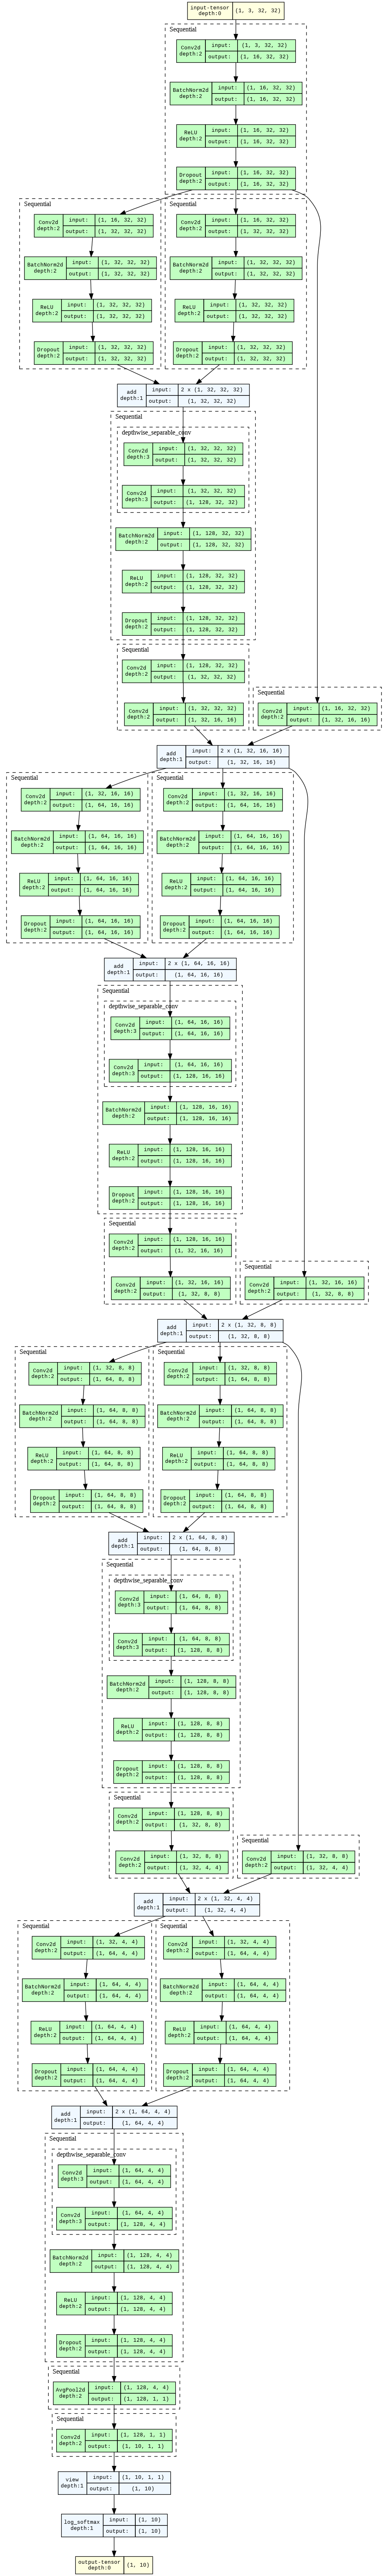

In [ ]:
from torchview import draw_graph
# model = Net()
# batch_size = 2
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(3, 32, 32), device='meta')
model_graph1 = draw_graph(Net(), input_size=(1,3,32,32), expand_nested=True, graph_dir = 'TB')
model_graph1.visual_graph